<a href="https://colab.research.google.com/github/kitty57/classifiers/blob/main/Cifar10_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

100%|██████████| 135107811/135107811 [00:03<00:00, 38500881.47it/s]


In [ ]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path='./data')

In [ ]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+"/train")
print(classes)

['test', 'train']
['truck', 'ship', 'dog', 'cat', 'deer', 'bird', 'automobile', 'airplane', 'frog', 'horse']


In [ ]:
a=os.listdir(data_dir+'/train/airplane')
len(a)

5000

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

In [ ]:
img,label=dataset[0]
img.shape,label

(torch.Size([3, 32, 32]), 0)

In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def show_example(img,label):
  print(dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

airplane


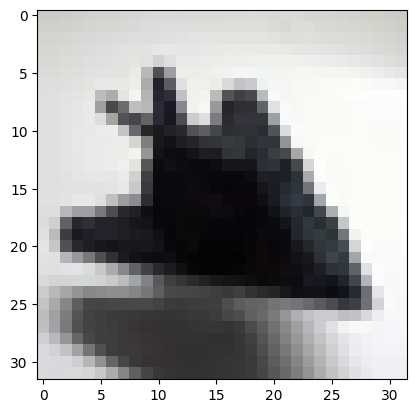

In [ ]:
show_example(*dataset[0])

In [ ]:
random_Seed=42
torch.manual_seed(random_Seed);

In [ ]:
val_size=5000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(45000, 5000)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [ ]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)

In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
  for img,label in dl:
    fig,ax=plt.subplots(figsize=(12,6))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(img,nrow=16).permute(1,2,0))

    break

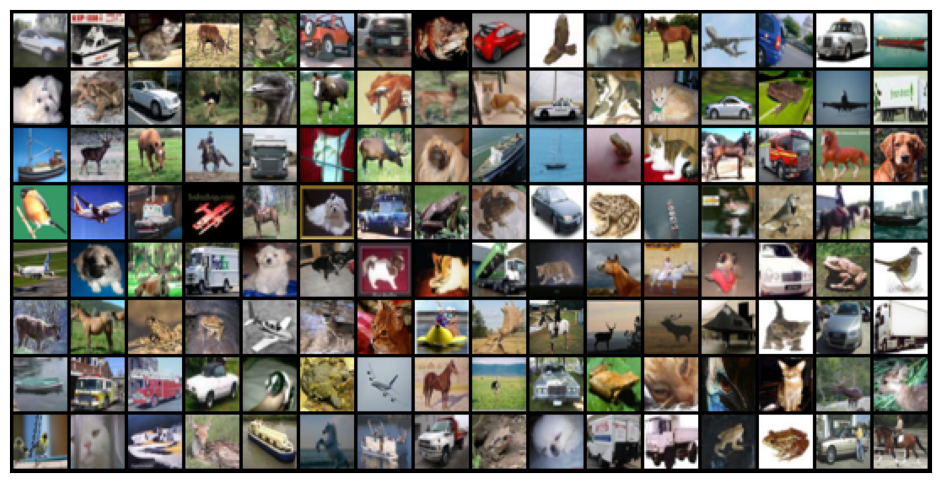

In [ ]:
show_batch(train_dl)

In [ ]:
def apply_kernel(img,kernel):
  ri,ci=img.shape
  rk,ck=kernel.shape
  ro,co=ri-rk+1,ci-ck+1
  op=torch.zeros([ro,co])
  for i in range(ro):
    for j in range(co):
      op[i,j]=torch.sum(img[i:i+rk,j:j+ck]+kernel)
  return op


In [ ]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
image    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[25., 25., 25.],
        [19., 21., 26.],
        [20., 17., 22.]])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
m=nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
)

In [ ]:
for img,label in train_dl:
  out=m(img)
  print(out.shape)
  break

torch.Size([128, 8, 16, 16])


In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    img,label=batch
    out=self(img)
    loss=F.cross_entropy(out,label)
    return loss
  def validation_step(self,batch):
    img,label=batch
    out=self(img)
    loss=F.cross_entropy(out,label)
    acc=accuracy(out,label)
    return {'val_loss':loss.detach(),'val_acc':acc}
  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss'] for x in outputs]
    epoch_loss=torch.stack(batch_losses).mean()
    batch_accs=[x['val_acc'] for x in outputs]
    epoch_acc=torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
  def epoch_end(self,epoch,result):
    print("Epoch [{}],train_loss:{:.4f},val_loss:{:.4f},val_acc:{:.4f}".format(epoch,result['train_loss'],result['val_loss'],result['val_acc']))
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class cifar10model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),#(32,32,32)
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),#(64,32,32)
        nn.ReLU(),
        nn.MaxPool2d(2,2),#(64,16,16)

        nn.Conv2d(64,128,kernel_size=3,padding=1),#(128,16,16)
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1),#(128,16,16)
        nn.ReLU(),
        nn.MaxPool2d(2,2),#(128,8,8)

        nn.Conv2d(128,256,kernel_size=3,padding=1),#(256,8,8)
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,padding=1),#(256,8,8)
        nn.ReLU(),
        nn.MaxPool2d(2,2),#(256,4,4)

        nn.Flatten(),
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

  def forward(self,xb):
    return self.network(xb)


In [ ]:
model=cifar10model()
model

cifar10model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [ ]:
for img,label in train_dl:
  print(img.shape)
  out=model(img)
  print(out.shape)
  break

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)
to_device(model,device);


In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    model.train()
    train_losses=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    model.epoch_end(epoch,result)
    history.append(result)
  return history


In [ ]:
model=to_device(cifar10model(),device)

In [ ]:
evaluate(model,val_dl)

{'val_loss': 2.3027944564819336, 'val_acc': 0.10296414792537689}

In [ ]:
num_epochs=10
opt_func=torch.optim.Adam
lr=1e-3

In [ ]:
history=fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0],train_loss:1.7905,val_loss:1.4751,val_acc:0.4592
Epoch [1],train_loss:1.2582,val_loss:1.1157,val_acc:0.5980
Epoch [2],train_loss:0.9998,val_loss:0.9499,val_acc:0.6683
Epoch [3],train_loss:0.8254,val_loss:0.8717,val_acc:0.6962
Epoch [4],train_loss:0.6924,val_loss:0.7733,val_acc:0.7260
Epoch [5],train_loss:0.5831,val_loss:0.7433,val_acc:0.7447
Epoch [6],train_loss:0.4842,val_loss:0.7151,val_acc:0.7606
Epoch [7],train_loss:0.3819,val_loss:0.7136,val_acc:0.7748
Epoch [8],train_loss:0.2962,val_loss:0.8426,val_acc:0.7605
Epoch [9],train_loss:0.2334,val_loss:0.8922,val_acc:0.7592


In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.9417237639427185, 'val_acc': 0.759472668170929}

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


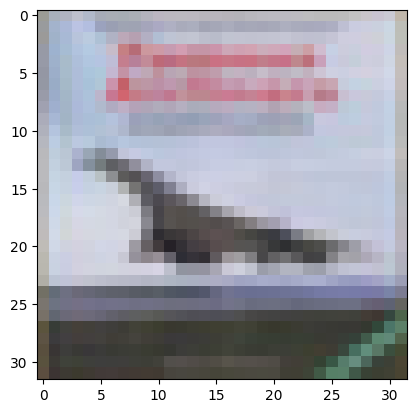

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))